In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

In [2]:
column_names = ["Inode (file unique ID)",
"KB Allocated",
"File Size",
"Creation Time in days from today",
"Change Time in days from today",
"Modification time in days from today",
"Acces time in days from today",
"GID numeric ID for the group owner of the file",
"UID numeric ID for the owner of the file"]
df = pd.read_csv("/mnt/research/CMSE495-SS24-ICER/file_system_usage/gpfs-stats/inode-size-age-jan-23",header=None, names = column_names, sep=" ",nrows=1000000)
df


,Inode (file unique ID),KB Allocated,File Size,Creation Time in days from today,Change Time in days from today,Modification time in days from today,Acces time in days from today,GID numeric ID for the group owner of the file,UID numeric ID for the owner of the file
0,100663296,0,8,1447,1447,3131,1447,2035,762231
1,100663297,0,188,1447,1447,1937,1447,2010,614955
2,100663301,0,567,1447,1447,3142,1447,2035,762231
3,100663304,0,87,1447,1447,3142,1447,2035,762231
4,100663306,0,1689,1447,1447,1937,1447,2010,614955
...,...,...,...,...,...,...,...,...,...
999995,101864705,64,17304,1447,1447,3316,1447,2003,785573
999996,101864706,64,7162,1447,1093,2083,1050,2022,500120
999997,101864708,64,3912,1447,1447,1999,1447,2010,839641
999998,101864710,128,126962,735,735,735,735,2035,762231


In [4]:
df["underutilizer"] = df['File Size']/1000 - df['KB Allocated'] + 3000 
df.head()

,Inode (file unique ID),KB Allocated,File Size,Creation Time in days from today,Change Time in days from today,Modification time in days from today,Acces time in days from today,GID numeric ID for the group owner of the file,UID numeric ID for the owner of the file,underutilizer
0,100663296,0,8,1447,1447,3131,1447,2035,762231,3000.008
1,100663297,0,188,1447,1447,1937,1447,2010,614955,3000.188
2,100663301,0,567,1447,1447,3142,1447,2035,762231,3000.567
3,100663304,0,87,1447,1447,3142,1447,2035,762231,3000.087
4,100663306,0,1689,1447,1447,1937,1447,2010,614955,3001.689


In [5]:
Q1 = df['underutilizer'].quantile(0.25)
Q3 = df['underutilizer'].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[(df['underutilizer'] >= (Q1 - 1.5 * IQR)) & 
                    (df['underutilizer'] <= (Q3 + 1.5 * IQR))]
# dataframe with out outliers
df2=df_no_outliers
df2.head()

,Inode (file unique ID),KB Allocated,File Size,Creation Time in days from today,Change Time in days from today,Modification time in days from today,Acces time in days from today,GID numeric ID for the group owner of the file,UID numeric ID for the owner of the file,underutilizer
0,100663296,0,8,1447,1447,3131,1447,2035,762231,3000.008
1,100663297,0,188,1447,1447,1937,1447,2010,614955,3000.188
2,100663301,0,567,1447,1447,3142,1447,2035,762231,3000.567
3,100663304,0,87,1447,1447,3142,1447,2035,762231,3000.087
4,100663306,0,1689,1447,1447,1937,1447,2010,614955,3001.689


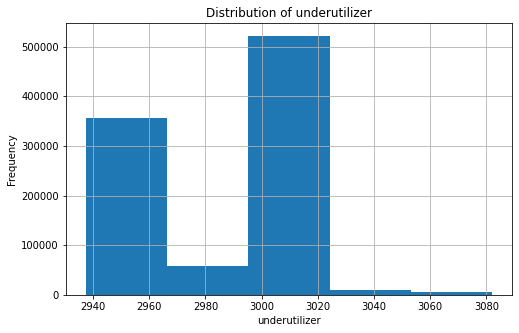

In [6]:
selected_column = 'underutilizer'
df2[selected_column].hist(bins=5, figsize=(8, 5))
plt.title(f'Distribution of {selected_column}')
plt.xlabel(selected_column)
plt.ylabel('Frequency')
plt.show()

In [7]:
column_min = df2['underutilizer'].min()
column_max = df2['underutilizer'].max()

print(f"The range of values in 'column_name' is from {column_min} to {column_max}")

The range of values in 'column_name' is from 2937.542 to 3081.96


In [8]:
num_bins = 5
bin_width = (df2['underutilizer'].max() - df2['underutilizer'].min()) / num_bins

# Create bins
bins = [df2['underutilizer'].min() + i * bin_width for i in range(num_bins + 1)]

labels = [f'Bin {i+1}' for i in range(num_bins)]

df2.loc[:, 'bin'] = pd.cut(df2['underutilizer'], bins=bins, labels=labels, include_lowest=True)


/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [9]:
df2

,Inode (file unique ID),KB Allocated,File Size,Creation Time in days from today,Change Time in days from today,Modification time in days from today,Acces time in days from today,GID numeric ID for the group owner of the file,UID numeric ID for the owner of the file,underutilizer,bin
0,100663296,0,8,1447,1447,3131,1447,2035,762231,3000.008,Bin 3
1,100663297,0,188,1447,1447,1937,1447,2010,614955,3000.188,Bin 3
2,100663301,0,567,1447,1447,3142,1447,2035,762231,3000.567,Bin 3
3,100663304,0,87,1447,1447,3142,1447,2035,762231,3000.087,Bin 3
4,100663306,0,1689,1447,1447,1937,1447,2010,614955,3001.689,Bin 3
...,...,...,...,...,...,...,...,...,...,...,...
999995,101864705,64,17304,1447,1447,3316,1447,2003,785573,2953.304,Bin 1
999996,101864706,64,7162,1447,1093,2083,1050,2022,500120,2943.162,Bin 1
999997,101864708,64,3912,1447,1447,1999,1447,2010,839641,2939.912,Bin 1
999998,101864710,128,126962,735,735,735,735,2035,762231,2998.962,Bin 3


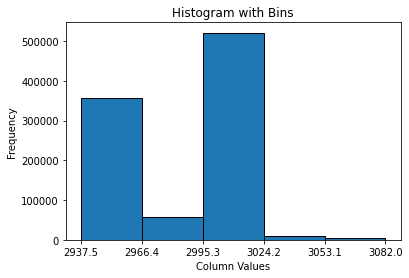

In [10]:
plt.hist(df['underutilizer'], bins=bins, edgecolor='black')
plt.xlabel('Column Values')
plt.ylabel('Frequency')
plt.title('Histogram with Bins')
plt.xticks(bins)
plt.show()

In [11]:
X = df2.drop(['underutilizer', 'bin'], axis=1)
y = df2['bin']
sample_size = int(0.1 * len(df))
X1=X.sample(n=sample_size, random_state=42)
y1=y.sample(n=sample_size,random_state=42)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9418


In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 7081    77   354     8     4]
 [  112  1019    33    17     5]
 [  281    72 10589    17     9]
 [   35    28    27   108    11]
 [   13    18    22    21    39]]


In [14]:
param_grid = {'n_neighbors': [1,3, 5, 7, 9], 
              'weights': ['uniform', 'distance']
             }

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Accuracy: 0.9496
Confusion Matrix:
[[ 7157    62   291     7     7]
 [   85  1029    43    23     6]
 [  254    49 10624    19    22]
 [   23    28    20   126    12]
 [    5     9    22    21    56]]


In [15]:
y_pred2=best_knn_model.predict(X)
accuracy = accuracy_score(y, y_pred2)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9557117580251124
